In [31]:
import numpy as np
import pandas as pd
import plotly.express as px
from matplotlib import pyplot as plt
from ydata_profiling import ProfileReport

from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

pd.options.display.max_columns = None

Leemos el dataset, que está en formato CSV desde google drive.
Adicionalmente renombro a las columnas en un formato mas comodo de manejar

In [32]:
df = pd.read_csv(
    'https://drive.google.com/uc?export=download&id=1gq-wDn_dwz_5uHSEoMYmQtnNrmnfNiXS'
)
df.rename(columns={c: c.lower().replace(" ", "_") for c in df.columns}, inplace=True)

In [33]:
df.head()

name gender eye_color               race hair_color  height  \
0       A-Bomb   Male    yellow              Human    No Hair   203.0   
1   Abe Sapien   Male      blue      Icthyo Sapien    No Hair   191.0   
2     Abin Sur   Male      blue            Ungaran    No Hair   185.0   
3  Abomination   Male     green  Human / Radiation    No Hair   203.0   
4      Abraxas   Male      blue      Cosmic Entity      Black   -99.0   

           publisher skin_color alignment  weight  
0      Marvel Comics          -      good   441.0  
1  Dark Horse Comics       blue      good    65.0  
2          DC Comics        red      good    90.0  
3      Marvel Comics          -       bad   441.0  
4      Marvel Comics          -       bad   -99.0

In [34]:
# Usando pandas profiling
report = ProfileReport(df, title='superhéroes', minimal=True)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Verificando la "calidad" de los datos

#### Chequeo de valores NULOS

Los valores nulos pueden tener distintas formas de ser represantados:
- nan
- vacios ""
- algun caracter especial "_", "?", "NULL"
- valores que no tienen sentido dado la variable (ej: distancia recorrida: -1)

En el caso del dataset de los superheroes, que valores nulos vemos?
> En el head vimos que "Skin color" tiene un "-" .
Que otras columnas tienen "-" ?

In [35]:
tienen_guion = df.astype('str').eq('-').any(axis=0)
tienen_guion

name          False
gender         True
eye_color      True
race           True
hair_color     True
height        False
publisher     False
skin_color     True
alignment      True
weight        False
dtype: bool

> Vemos que estas columnas columnas tienen valores con "-":
- gender
- eye_color
- race
- hair_color
- skin_color
- alignment

In [36]:
# Asi se haria para quedarnos con las FILAS que tienen "-" en alguna de sus columnas

df[df.astype('str').eq('-').any(axis=1)]

name  gender eye_color               race        hair_color  \
0             A-Bomb    Male    yellow              Human           No Hair   
3        Abomination    Male     green  Human / Radiation           No Hair   
4            Abraxas    Male      blue      Cosmic Entity             Black   
5      Absorbing Man    Male      blue              Human           No Hair   
6        Adam Monroe    Male      blue                  -             Blond   
..               ...     ...       ...                ...               ...   
727      Yellow Claw    Male      blue                  -           No Hair   
728     Yellowjacket    Male      blue              Human             Blond   
729  Yellowjacket II  Female      blue              Human  Strawberry Blond   
732          Zatanna  Female      blue              Human             Black   
733             Zoom    Male       red                  -             Brown   

     height      publisher skin_color alignment  weight  
0     203.0  Marvel Comics          -      good   441.0  
3     203.0  Marvel Comics          -       bad   441.0  
4     -99.0  Marvel Comics          -       bad   -99.0  
5     193.0  Marvel Comics          -       bad   122.0  
6     -99.0   NBC - Heroes          -      good   -99.0  
..      ...            ...        ...       ...     ...  
727   188.0  Marvel Comics          -       bad    95.0  
728   183.0  Marvel Comics          -      good    83.0  
729   165.0  Marvel Comics          -      good    52.0  
732   170.0      DC Comics          -      good    57.0  
733   185.0      DC Comics          -       bad    81.0  

[675 rows x 10 columns]

> Convertimos los valores "-" en nan

In [37]:
df = df.replace('-', np.nan)

> Un ejemplo de ver valores nan se hace con la funcion .isna()

In [38]:
df[df.alignment.isna()]

name gender eye_color           race hair_color  height  \
33        Anti-Venom   Male      blue       Symbiote      Blond   229.0   
110        Blackwulf   Male       red          Alien      White   188.0   
138       Brundlefly   Male       NaN         Mutant        NaN   193.0   
426  Man of Miracles    NaN      blue  God / Eternal     Silver   -99.0   
535                Q   Male       NaN  God / Eternal        NaN   -99.0   
676        Trickster   Male      blue          Human      Blond   183.0   
692        Venompool   Male       NaN       Symbiote        NaN   226.0   

         publisher skin_color alignment  weight  
33   Marvel Comics        NaN       NaN   358.0  
110  Marvel Comics        NaN       NaN    88.0  
138            NaN        NaN       NaN   -99.0  
426   Image Comics        NaN       NaN   -99.0  
535      Star Trek        NaN       NaN   -99.0  
676      DC Comics        NaN       NaN    81.0  
692  Marvel Comics        NaN       NaN   -99.0

> Hay alguna variable que este en "blanco" ?

In [42]:
df.astype('str').eq('').any(axis=0)

name          False
gender        False
eye_color     False
race          False
hair_color    False
height        False
publisher     False
skin_color    False
alignment     False
weight        False
dtype: bool

> Vemos que ninguna variable esta en blanco  
> Nota: Siendo un poco más putitanos deberiamos chequear que :
- por medio de la regex "^-*[0-9]*\$" fijarnos que las columnas de numeros contengan solo numeros
- por medio de la regex "^ *\$" fijarnos que no haya varios valores de vacios (lo mismo para otros caracteres que sospechamos que pueden ser usados para representar un valor NULO

#### Chequeo de variables numericas:

> Ahora vamos a chequear los limites de las columnas que tengan valores numericos.  
Las columnas edad y peso no deberian tener valores negativos.

In [45]:
# Nota: observar como uso .to_frame() para convertir una pd.Series en un pd.DataFrame 
# para que se vea "bonito"

columnas_con_numeros = ['height', 'weight']
(df[columnas_con_numeros] < 0).any().to_frame('Menor que 0 ?')

Menor que 0 ?
height           True
weight           True

In [46]:
for c in columnas_con_numeros:
    print(c)
    display(df[df[c] < 0][c].value_counts().to_frame())
    print()

height


count
height       
-99.0     217


weight


count
weight       
-99.0     237

> Pasamos los valores -99 de las columnas height y weight a nan

In [47]:
df = df.replace({'height': -99.0, 'weight': -99.0}, value=np.nan)

#### Duplicados:
> Dependiendo del dataset, a veces tenemos informacion duplicada que no queremos  
> Alertamos una fila duplicada, la eliminamos


>  df.duplicated()   -> devuelve una serie de booleanos indicando se una fila es duplicada o no  
df.drop_duplicates() -> devuelve un dataframe nuevo con las filas duplicadas eliminadas  

> Nota: podemos pasarle el parametro subset=\<columnas a mirar> para solo considerar algunas columnas para ver si esta duplicado o no

In [49]:
df[df.duplicated(keep=False)]

name gender eye_color   race hair_color  height      publisher  \
290  Goliath   Male       NaN  Human        NaN     NaN  Marvel Comics   
291  Goliath   Male       NaN  Human        NaN     NaN  Marvel Comics   

    skin_color alignment  weight  
290        NaN      good     NaN  
291        NaN      good     NaN

También podemos chequear duplicados por columnas y no que toda la fila sea igual

In [50]:
df[df.duplicated(subset=['name'],keep=False)]

name  gender eye_color            race hair_color  height  \
22            Angel    Male      blue             NaN      Blond   183.0   
23            Angel    Male       NaN         Vampire        NaN     NaN   
47            Atlas    Male     brown          Mutant        Red   183.0   
48            Atlas    Male      blue   God / Eternal      Brown   198.0   
49             Atom    Male      blue             NaN        Red   178.0   
50             Atom    Male       NaN             NaN        NaN     NaN   
62          Batgirl  Female       NaN             NaN        NaN     NaN   
63          Batgirl  Female     green           Human        Red   170.0   
68           Batman    Male      blue           Human      black   188.0   
69           Batman    Male      blue           Human      Black   178.0   
96     Black Canary  Female      blue           Human      Blond   165.0   
97     Black Canary  Female      blue       Metahuman      Blond   170.0   
115        Blizzard    Male       NaN             NaN        NaN     NaN   
116        Blizzard    Male       NaN             NaN      Brown     NaN   
122     Blue Beetle    Male      blue             NaN      Brown     NaN   
123     Blue Beetle    Male       NaN             NaN        NaN     NaN   
155  Captain Marvel  Female      blue      Human-Kree      Blond   180.0   
156  Captain Marvel    Male      blue           Human      Black   193.0   
259       Firestorm    Male     brown             NaN      Black     NaN   
260       Firestorm    Male      blue           Human     Auburn   188.0   
289         Goliath    Male       NaN             NaN        NaN     NaN   
290         Goliath    Male       NaN           Human        NaN     NaN   
291         Goliath    Male       NaN           Human        NaN     NaN   
481           Namor    Male       NaN             NaN        NaN     NaN   
482           Namor    Male      grey       Atlantean      Black   188.0   
496            Nova    Male     brown           Human      Brown   185.0   
497            Nova  Female     white  Human / Cosmic        Red   163.0   
617          Speedy    Male       NaN           Human        NaN     NaN   
618          Speedy  Female     green           Human      Brown     NaN   
622      Spider-Man    Male     hazel           Human      Brown   178.0   
623      Spider-Man     NaN       red           Human      Brown   178.0   
624      Spider-Man    Male     brown           Human      Black   157.0   
673           Toxin    Male      blue        Symbiote      Brown   188.0   
674           Toxin    Male     black        Symbiote      Blond   191.0   
695      Vindicator  Female     green           Human        Red   165.0   
696      Vindicator    Male       NaN             NaN        NaN     NaN   

             publisher skin_color alignment  weight  
22       Marvel Comics        NaN      good    68.0  
23   Dark Horse Comics        NaN      good     NaN  
47       Marvel Comics        NaN      good   101.0  
48           DC Comics        NaN       bad   126.0  
49           DC Comics        NaN      good    68.0  
50           DC Comics        NaN      good     NaN  
62           DC Comics        NaN      good     NaN  
63           DC Comics        NaN      good    57.0  
68           DC Comics        NaN      good    95.0  
69           DC Comics        NaN      good    77.0  
96           DC Comics        NaN      good    58.0  
97           DC Comics        NaN      good    59.0  
115      Marvel Comics        NaN       bad     NaN  
116      Marvel Comics        NaN       bad     NaN  
122          DC Comics        NaN      good     NaN  
123          DC Comics        NaN      good     NaN  
155      Marvel Comics        NaN      good    74.0  
156          DC Comics        NaN      good   101.0  
259          DC Comics        NaN      good     NaN  
260          DC Comics        NaN      good    91.0  
289      Marvel Comics        NaN      good     NaN  
290      Marve

In [51]:
size_antes = len(df)
df = df.drop_duplicates()
size_despues = len(df)
print(f'se eliminaron: {size_antes-size_despues} filas duplicadas')

se eliminaron: 1 filas duplicadas


> Nota: a veces es util "resetear" el indice despues de eliminar filas (ya sea por drop duplicates o por algun otro filtro)

In [52]:
df.reset_index(drop=True, inplace=True)

# Conversion de Variables

En esta sección mostraremos las principales estrategias para convertir variables según su tipo.

## Conversion de variables categoricas:
Hay veces que tenemos que trabajar un poco en las variables que tenemos para que puedan ser usadas en los modelos.

### Preguntas antes de empezar:
- Alta vs Baja Cardinalidad de una Variable Categorica, que significa ?
- Que significa que una Variable contenga informacion del Orden?

### Categóricas de baja cardinalidad

Sklearn eligió unos nombres un poco desafortunados para los metodos de traformacion de variables categoricas:
Los principales son:
- Ordinal Encoder
- Label Encoder
- One Hot Encoding

No hay mucha diferencia entre Label Encoder y Ordinal Encoder ya que los dos tienen la misma logica, la principal diferencia es que Label Encoder esta pensada para trabajar con solo una serie por vez, en cambio Ordinal Encoder puede trabajar con todas las columnas al mismo tiempo.

El motivo que digo que los nombres son un poco desafortunados es que Ordinal Encoder da a entender que hay una especie de orden en el encoding que haga, pero la verdad es que no hay ningun criterio en el mismo, si queremos que la transformacion mantenga un cierto orden que nosotros queremos, entonces tenemos que hacer nosotros mismos la misma.

#### Ordinal Encoder
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html


Por cada valor de la variable categórica asigna un valor entero

In [53]:
oe = OrdinalEncoder(dtype='int')
columns_to_encode = ['eye_color', 'gender']
try:
    df[['eye_color_encoded', 'gender_encoded']] = oe.fit_transform(
        df[columns_to_encode]
    )
except Exception as upa:
    print(f'Apa lalanga: {upa}')

Apa lalanga: There are missing values in features [0, 1]. For OrdinalEncoder to encode missing values with dtype: int, set encoded_missing_value to a non-nan value, or set dtype to a float


> Una posible opcion para tratar con nans, es reconocerlo como tal y asignarle su propia categoria

In [54]:
# Aca vemos como pasar el nan al texto "nan" y por lo tanto es un "nuevo" color
df['eye_color'].astype(str).unique()

array(['yellow', 'blue', 'green', 'brown', 'nan', 'red', 'violet',
       'white', 'purple', 'black', 'grey', 'silver', 'yellow / red',
       'yellow (without irises)', 'gold', 'blue / white', 'hazel',
       'green / blue', 'white / red', 'indigo', 'amber', 'yellow / blue',
       'bown'], dtype=object)

In [55]:
# Convertimos nulos a string 'nan', es decir un valor posible mas para que no explote
df[['eye_color_encoded', 'gender_encoded']] = oe.fit_transform(
    df[columns_to_encode].astype(str)
)

In [56]:
df[['eye_color', 'eye_color_encoded', 'gender', 'gender_encoded']]

eye_color  eye_color_encoded  gender  gender_encoded
0      yellow                 19    Male               1
1        blue                  2    Male               1
2        blue                  2    Male               1
3       green                  7    Male               1
4        blue                  2    Male               1
..        ...                ...     ...             ...
728      blue                  2  Female               0
729     white                 17    Male               1
730     brown                  5    Male               1
731      blue                  2  Female               0
732       red                 14    Male               1

[733 rows x 4 columns]

> Una funcionalidad MUY interesante de muchas de las clases de sklearn que ayudan en la transformacion de
es que tienen la transformacion INVERSA!

In [57]:
oe.inverse_transform(df[['eye_color_encoded', 'gender_encoded']])

array([['yellow', 'Male'],
       ['blue', 'Male'],
       ['blue', 'Male'],
       ...,
       ['brown', 'Male'],
       ['blue', 'Female'],
       ['red', 'Male']], dtype=object)

In [58]:
df['gender_encoded'].value_counts()

gender_encoded
1    504
0    200
2     29
Name: count, dtype: int64

**Pregunta del millon**:
- Esta todo bien con esta trasnformacion??
- Puedo usar las columnas 'eye_color_encoded' y 'gender_encoded' ??

#### Label Encoder
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

Es exactamente la misma idea pero esperando una sola variable ya que se usa para encodear la variable target de un modelo predictivo

In [59]:
le = LabelEncoder()
# Convertimos nulos a string 'nan', es decir un valor posible mas
df['alignment_encoded'] = le.fit_transform(df['alignment'].astype(str))

In [60]:
df[['alignment', 'alignment_encoded']]

alignment  alignment_encoded
0        good                  1
1        good                  1
2        good                  1
3         bad                  0
4         bad                  0
..        ...                ...
728      good                  1
729      good                  1
730      good                  1
731      good                  1
732       bad                  0

[733 rows x 2 columns]

> Al igual que la clase anterior, se puede usar el inverso

In [61]:
le.inverse_transform(df.alignment_encoded)[:10]

array(['good', 'good', 'good', 'bad', 'bad', 'bad', 'good', 'good',
       'good', 'good'], dtype=object)


***Preguntas V/F***:
- Esta bien aplicar LabelEncoder() a la columna "alignment" ?
- OrdinalEncoder() o LabelEncoder() de sklearn pueden trabajar con una supuesta columna "orden" cuyos valores son \['primero','segundo','tercero'] y van a realizar el encoding correctamente ?

> Nota:
Hay veces que es muy util aplicar OrdinalEncoder() o LabelEncoder() a una variable NO ordinal si el modelo que va a usar los datos no va a utilizar el orden.


In [62]:
# borramos del dataframe las columnas que no nos interesan
# tambien se puede usar df = df.drop(columns=['alignment_encoded', 'eye_color_encoded', 'gender_encoded'])

del df['alignment_encoded']
del df['eye_color_encoded']
del df['gender_encoded']

#### One Hot Encoding

Crea una columna binaria por cada valor de la variable

In [63]:
ohe = OneHotEncoder()  # drop='first'
eye_color_encoded = (
    ohe.fit_transform(df[['eye_color']].astype(str)).todense().astype(int)
)
eye_color_encoded = pd.DataFrame(eye_color_encoded).add_prefix('ec_')
df = pd.concat([df, eye_color_encoded], axis=1)

In [64]:
df

name  gender eye_color               race        hair_color  \
0             A-Bomb    Male    yellow              Human           No Hair   
1         Abe Sapien    Male      blue      Icthyo Sapien           No Hair   
2           Abin Sur    Male      blue            Ungaran           No Hair   
3        Abomination    Male     green  Human / Radiation           No Hair   
4            Abraxas    Male      blue      Cosmic Entity             Black   
..               ...     ...       ...                ...               ...   
728  Yellowjacket II  Female      blue              Human  Strawberry Blond   
729             Ymir    Male     white        Frost Giant           No Hair   
730             Yoda    Male     brown     Yoda's species             White   
731          Zatanna  Female      blue              Human             Black   
732             Zoom    Male       red                NaN             Brown   

     height          publisher skin_color alignment  weight  ec_0  ec_1  ec_2  \
0     203.0      Marvel Comics        NaN      good   441.0     0     0     0   
1     191.0  Dark Horse Comics       blue      good    65.0     0     0     1   
2     185.0          DC Comics        red      good    90.0     0     0     1   
3     203.0      Marvel Comics        NaN       bad   441.0     0     0     0   
4       NaN      Marvel Comics        NaN       bad     NaN     0     0     1   
..      ...                ...        ...       ...     ...   ...   ...   ...   
728   165.0      Marvel Comics        NaN      good    52.0     0     0     1   
729   304.8      Marvel Comics      white      good     NaN     0     0     0   
730    66.0       George Lucas      green      good    17.0     0     0     0   
731   170.0          DC Comics        NaN      good    57.0     0     0     1   
732   185.0          DC Comics        NaN       bad    81.0     0     0     0   

     ec_3  ec_4  ec_5  ec_6  ec_7  ec_8  ec_9  ec_10  ec_11  ec_12  ec_13  \
0       0     0     0     0     0     0     0      0      0      0      0   
1       0     0     0     0     0     0     0      0      0      0      0   
2       0     0     0     0     0     0     0      0      0      0      0   
3       0     0     0     0     1     0     0      0      0      0      0   
4       0     0     0     0     0     0     0      0      0      0      0   
..    ...   ...   ...   ...   ...   ...   ...    ...    ...    ...    ...   
728     0     0     0     0     0     0     0      0      0      0      0   
729     0     0     0     0     0     0     0      0      0      0      0   
730     0     0     1     0     0     0     0      0      0      0      0   
731     0     0     0     0     0     0     0      0      0      0      0   
732     0     0     0     0     0     0     0      0      0      0      0   

     ec_14  ec_15  ec_16  ec_17  ec_18  ec_19  ec_20  ec_21  ec_22  
0        0      0      0      0      0      1      0      0      0  
1        0      0      0      0      0      0      0      0      0  
2        0      0      0      0      0      0      0      0      0  
3        0      0      0      0      0      0      0      0      0  
4        0      0      0      0      0      0      0      0      0  
..     ...    ...    ...    ...    ...    ...    ...    ...    ...  
728      0      0      0      0      0      0      0      0      0  
729      0      0      0      1      0      0      0      0      0  
730      0      0      0      0      0      0      0      0      0  
731      0      0      0      0      0      0      0      0      0  
732      1      0      0      0      0      0      0      0      0  

[733 rows x 33 columns]

In [65]:
ohe.categories_

[array(['amber', 'black', 'blue', 'blue / white', 'bown', 'brown', 'gold',
        'green', 'green / blue', 'grey', 'hazel', 'indigo', 'nan',
        'purple', 'red', 'silver', 'violet', 'white', 'white / red',
        'yellow', 'yellow (without irises)', 'yellow / blue',
        'yellow / red'], dtype=object)]

In [66]:
df[['eye_color'] + eye_color_encoded.columns.tolist()]

eye_color  ec_0  ec_1  ec_2  ec_3  ec_4  ec_5  ec_6  ec_7  ec_8  ec_9  \
0      yellow     0     0     0     0     0     0     0     0     0     0   
1        blue     0     0     1     0     0     0     0     0     0     0   
2        blue     0     0     1     0     0     0     0     0     0     0   
3       green     0     0     0     0     0     0     0     1     0     0   
4        blue     0     0     1     0     0     0     0     0     0     0   
..        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
728      blue     0     0     1     0     0     0     0     0     0     0   
729     white     0     0     0     0     0     0     0     0     0     0   
730     brown     0     0     0     0     0     1     0     0     0     0   
731      blue     0     0     1     0     0     0     0     0     0     0   
732       red     0     0     0     0     0     0     0     0     0     0   

     ec_10  ec_11  ec_12  ec_13  ec_14  ec_15  ec_16  ec_17  ec_18  ec_19  \
0        0      0      0      0      0      0      0      0      0      1   
1        0      0      0      0      0      0      0      0      0      0   
2        0      0      0      0      0      0      0      0      0      0   
3        0      0      0      0      0      0      0      0      0      0   
4        0      0      0      0      0      0      0      0      0      0   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
728      0      0      0      0      0      0      0      0      0      0   
729      0      0      0      0      0      0      0      1      0      0   
730      0      0      0      0      0      0      0      0      0      0   
731      0      0      0      0      0      0      0      0      0      0   
732      0      0      0      0      1      0      0      0      0      0   

     ec_20  ec_21  ec_22  
0        0      0      0  
1        0      0      0  
2        0      0      0  
3        0      0      0  
4        0      0      0  
..     ...    ...    ...  
728      0      0      0  
729      0      0      0  
730      0      0      0  
731      0      0      0  
732      0      0      0  

[733 rows x 24 columns]

In [67]:
df.drop(columns=eye_color_encoded.columns.tolist(), inplace=True)

Otra solución para OneHotEncoding implementada en pandas:

In [68]:
with_dummies = pd.get_dummies(df, columns=['eye_color'], dummy_na=True)
display(with_dummies.head(2))
print(with_dummies.shape)

name gender           race hair_color  height          publisher  \
0      A-Bomb   Male          Human    No Hair   203.0      Marvel Comics   
1  Abe Sapien   Male  Icthyo Sapien    No Hair   191.0  Dark Horse Comics   

  skin_color alignment  weight  eye_color_amber  eye_color_black  \
0        NaN      good   441.0            False            False   
1       blue      good    65.0            False            False   

   eye_color_blue  eye_color_blue / white  eye_color_bown  eye_color_brown  \
0           False                   False           False            False   
1            True                   False           False            False   

   eye_color_gold  eye_color_green  eye_color_green / blue  eye_color_grey  \
0           False            False                   False           False   
1           False            False                   False           False   

   eye_color_hazel  eye_color_indigo  eye_color_purple  eye_color_red  \
0            False             False             False          False   
1            False             False             False          False   

   eye_color_silver  eye_color_violet  eye_color_white  eye_color_white / red  \
0             False             False            False                  False   
1             False             False            False                  False   

   eye_color_yellow  eye_color_yellow (without irises)  \
0              True                              False   
1             False                              False   

   eye_color_yellow / blue  eye_color_yellow / red  eye_color_nan  
0                    False                   False          False  
1                    False                   False          False

(733, 32)


Para evitar problemas de colinealidad ***en los features*** se debe excluir una categoría del set (la ausencia de todas - vector de 0s - indica la presencia de la categoría faltante) <br>
La función de pandas ya viene con una parámetro para esto ***drop_first=True***:

In [69]:
with_dummies = pd.get_dummies(df, columns=['eye_color'], dummy_na=True, drop_first=True)
display(with_dummies.head(2))
print(with_dummies.shape)

name gender           race hair_color  height          publisher  \
0      A-Bomb   Male          Human    No Hair   203.0      Marvel Comics   
1  Abe Sapien   Male  Icthyo Sapien    No Hair   191.0  Dark Horse Comics   

  skin_color alignment  weight  eye_color_black  eye_color_blue  \
0        NaN      good   441.0            False           False   
1       blue      good    65.0            False            True   

   eye_color_blue / white  eye_color_bown  eye_color_brown  eye_color_gold  \
0                   False           False            False           False   
1                   False           False            False           False   

   eye_color_green  eye_color_green / blue  eye_color_grey  eye_color_hazel  \
0            False                   False           False            False   
1            False                   False           False            False   

   eye_color_indigo  eye_color_purple  eye_color_red  eye_color_silver  \
0             False             False          False             False   
1             False             False          False             False   

   eye_color_violet  eye_color_white  eye_color_white / red  eye_color_yellow  \
0             False            False                  False              True   
1             False            False                  False             False   

   eye_color_yellow (without irises)  eye_color_yellow / blue  \
0                              False                    False   
1                              False                    False   

   eye_color_yellow / red  eye_color_nan  
0                   False          False  
1                   False          False

(733, 31)


> La necesidad de eliminar una columna se ve más claramente para una categórica de dos valores, veamos el caso de *Gender*

In [70]:
gender_dummies = pd.get_dummies(df[['gender']],dummy_na=True, drop_first=True)
display(gender_dummies.tail(5))

gender_Male  gender_nan
728        False       False
729         True       False
730         True       False
731        False       False
732         True       False

>Con una sola columna tenemos toda la información necesaria

## Categóricas de alta cardinalidad

Que pasa con la variable *Race* que tiene mas de 60 valores, vamos a crear 60 variables? <br>
Veamos la distribución de los mismos

race
NaN                  304
Human                207
Mutant                63
God / Eternal         14
Human / Radiation     11
Cyborg                11
Android                9
Symbiote               9
Kryptonian             7
Alien                  7
Name: count, dtype: int64

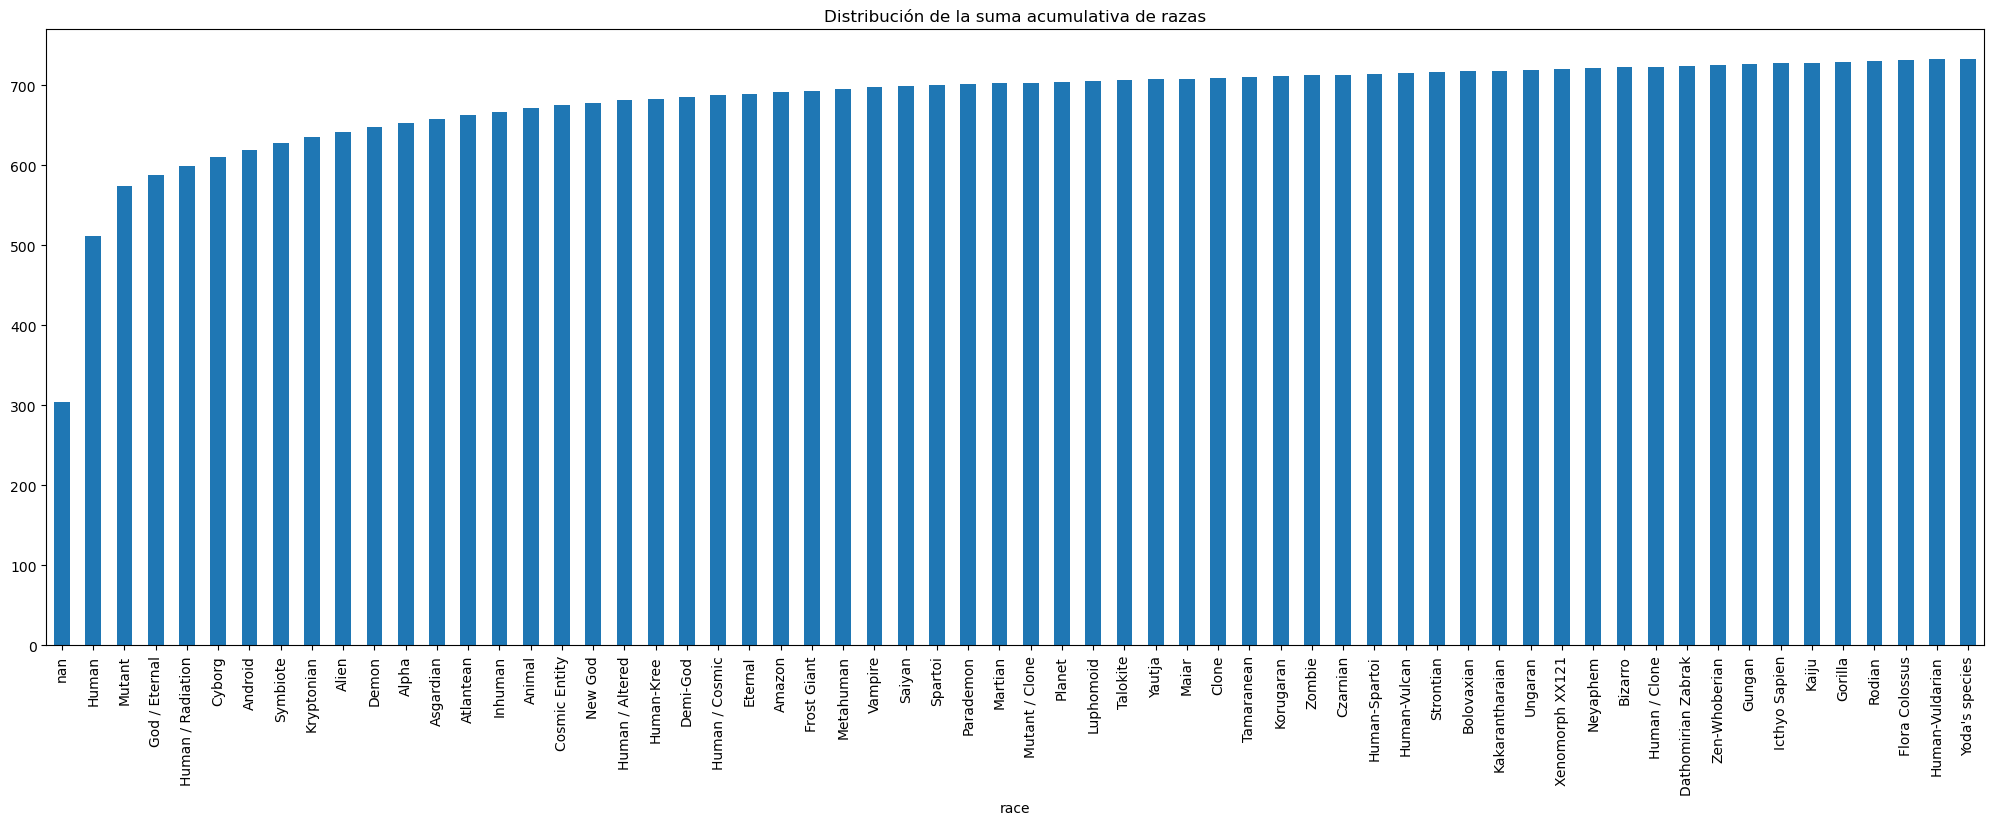

In [71]:
%matplotlib inline

unique_races = df['race'].value_counts(dropna=False)

# Mostrar los primeros 10 valores únicos de la columna 'race'
display(unique_races.head(10))

# Crear la gráfica de barra con la suma acumulativa
unique_races.cumsum().plot(
    kind='bar', title="Distribución de la suma acumulativa de razas", figsize=(25, 8)
)

# Asegurarse de mostrar la gráfica
plt.show()

>Con el top 10 cubrimos mas del 85% de la data

>Hay varias cosas que podemos hacer para reducir la dimensionalidad  
>Veamos 2 (hay mas)

Una opcion es mapear todas las variables que tienen muy pocas apariciones en una mas grande


In [72]:
races = df.race.value_counts()

In [73]:
races = races[races < 2].index
races

Index(['Spartoi', 'Parademon', 'Martian', 'Mutant / Clone', 'Planet',
       'Luphomoid', 'Talokite', 'Yautja', 'Maiar', 'Clone', 'Tamaranean',
       'Korugaran', 'Zombie', 'Czarnian', 'Human-Spartoi', 'Human-Vulcan',
       'Strontian', 'Bolovaxian', 'Kakarantharaian', 'Ungaran',
       'Xenomorph XX121', 'Neyaphem', 'Bizarro', 'Human / Clone',
       'Dathomirian Zabrak', 'Zen-Whoberian', 'Gungan', 'Icthyo Sapien',
       'Kaiju', 'Gorilla', 'Rodian', 'Flora Colossus', 'Human-Vuldarian',
       'Yoda's species'],
      dtype='object', name='race')

In [78]:
races = df.race.value_counts()
races = races[races < 2].index

df.race.replace(to_replace = races, value='other').value_counts().to_frame().shape

# Nota: Esto se guardaria en el dataframe haciendo
# df['race'] = df.race.replace(to_replace = races, value='other')

(28, 1)

Otra opcion es producir un hash que tenga una dimension menor a las columnas del one hot

In [85]:
df['race'] = df['race'].apply(lambda x: [x])

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html
fh = FeatureHasher(n_features=3, input_type='string')
hashed_features = fh.fit_transform(df['race'].astype(str)).todense()
hashed_features = pd.DataFrame(hashed_features).add_prefix('race_')
pd.concat([df[['race']], hashed_features], ignore_index=True, axis=1)

## Numéricas

En el set tenemos dos variables numéricas, *Weight* y *Height* veamos su distribución

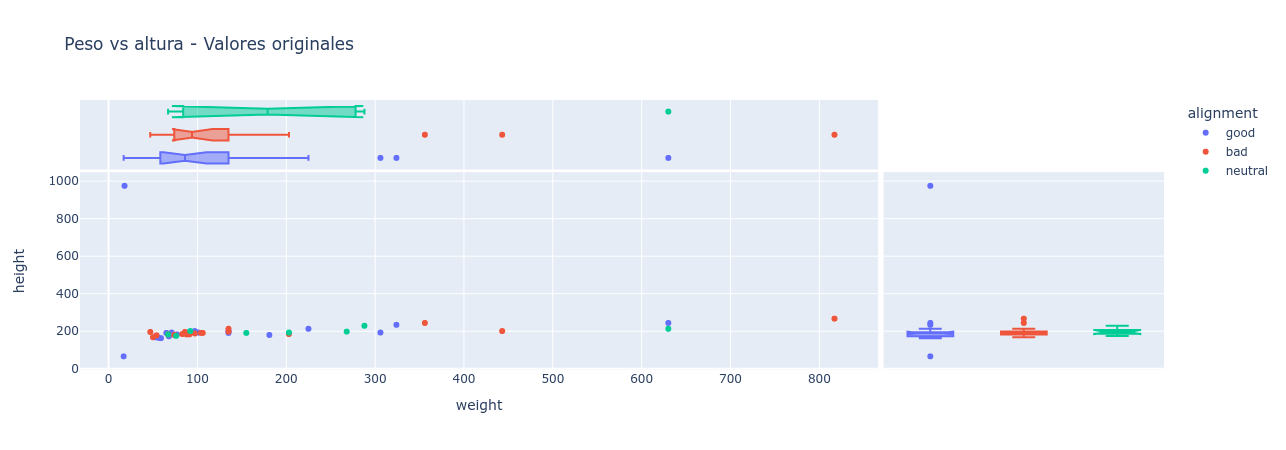

weight  height
count  495.00  517.00
mean   112.25  186.73
std    104.15   59.25
min      2.00   15.20
25%     61.00  173.00
50%     81.00  183.00
75%    108.00  191.00
max    900.00  975.00

In [87]:
def plot_weight_vs_height(df, title=""):
    fig = px.scatter(
        df.dropna(),
        x="weight",
        y="height",
        color="alignment",
        marginal_x="box",
        marginal_y="box",
        hover_name='name',
        title="Peso vs altura " + title,
    )
    fig.update_layout(autosize=False, width=1000)
    fig.show()
    display(round(df[['weight', 'height']].describe(), 2))


# _df = df[df.alignment != 'neutral'].reset_index(drop=True)
plot_weight_vs_height(df, "- Valores originales")

>Se observa una dispersión mucho mas grande de valores en el peso que en la altura.

### Scalers

Aparece el concepto de *Scaler*, una transformación por la cual escalamos a un determinado rango/distribución, veamos distintas implementaciones:

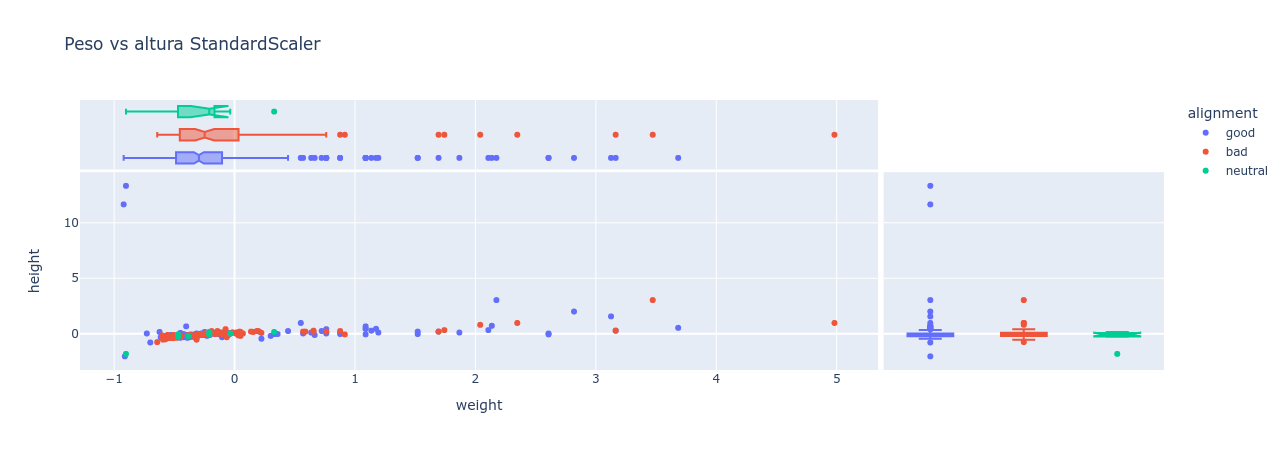

weight  height
count  313.00  313.00
mean    -0.05    0.03
std      0.80    1.08
min     -0.92   -2.05
25%     -0.47   -0.20
50%     -0.30   -0.07
75%     -0.07    0.02
max      4.98   13.34

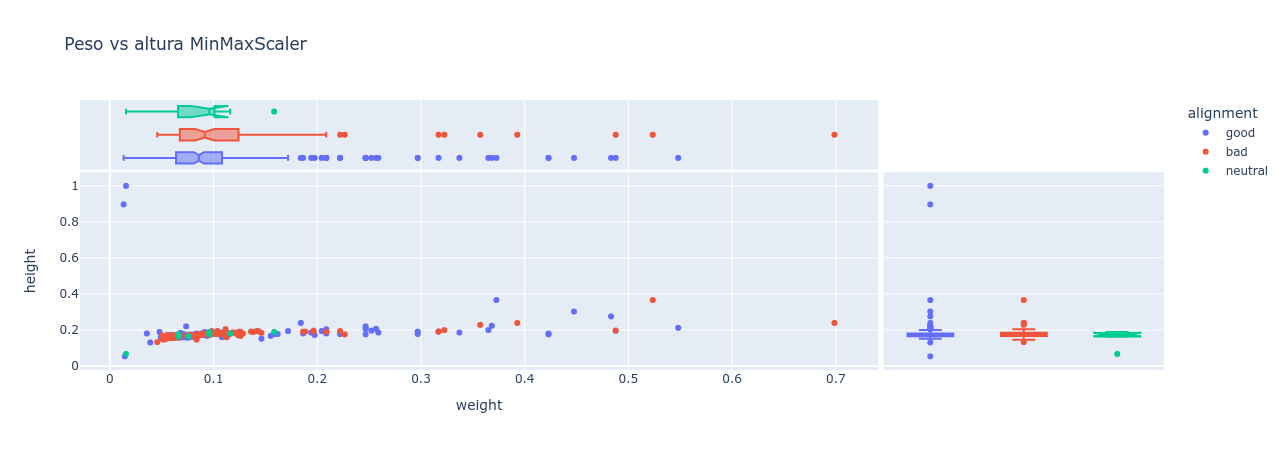

weight  height
count  313.00  313.00
mean     0.11    0.18
std      0.09    0.07
min      0.01    0.05
25%      0.07    0.17
50%      0.09    0.17
75%      0.11    0.18
max      0.70    1.00

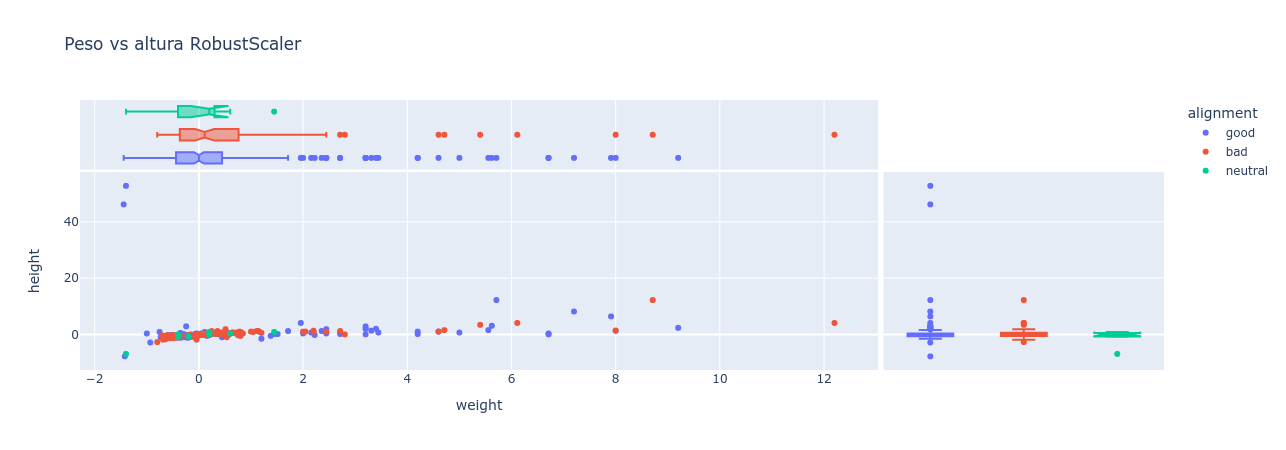

weight  height
count  313.00  313.00
mean     0.58    0.38
std      1.85    4.26
min     -1.44   -7.80
25%     -0.40   -0.53
50%      0.00    0.00
75%      0.51    0.33
max     12.20   52.80

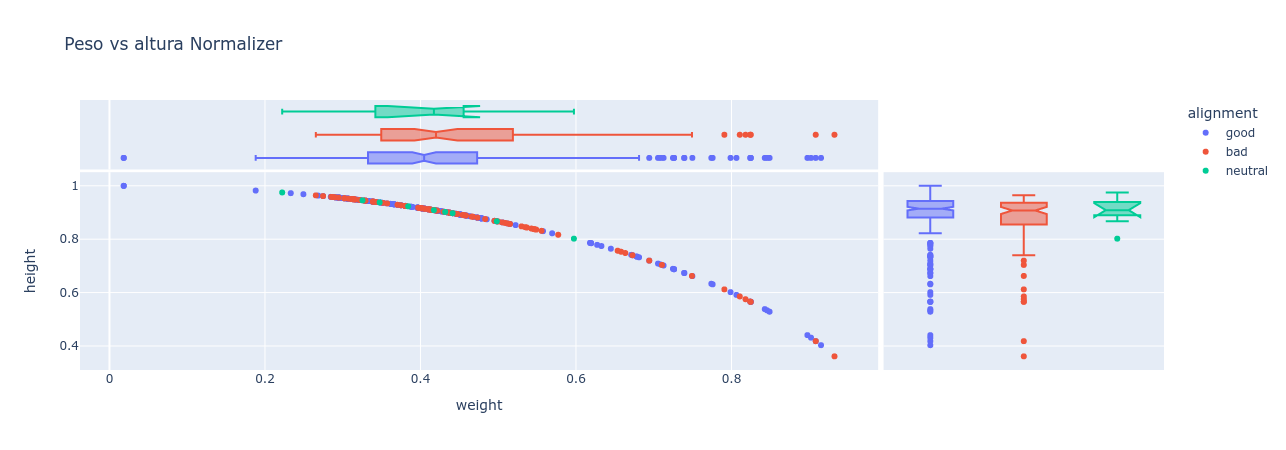

weight  height
count  313.00  313.00
mean     0.45    0.87
std      0.16    0.11
min      0.02    0.36
25%      0.34    0.88
50%      0.41    0.91
75%      0.48    0.94
max      0.93    1.00

In [88]:
# StandardScaler   -> promedio=0, desviacion estandar=1                       (cada feature)
# MinMaxScaler     -> escala valores de 0 a 1, (o rango pasado por parametro) (cada feature)
# RobustScaler     -> escala siendo robusto a outliers                        (cada feature)
# Normalizer       -> modifica los datos para que tengan norma=1              (cada fila) puede servir para calculos de ciertas distancias entre las isntancias como la distancia coseno

scalers = [
    StandardScaler(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
    MinMaxScaler(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
    RobustScaler(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
    Normalizer(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
]

_df = df[['name', 'alignment', 'weight', 'height']].dropna()
cols_to_transform = ['weight', 'height']
df_to_scale = _df[cols_to_transform]

for scaler in scalers:
    scaled_values = scaler.fit_transform(df_to_scale)
    scaled_values = pd.DataFrame(scaled_values, columns=cols_to_transform)
    df_transformed = _df[['name', 'alignment']].join(scaled_values)
    plot_weight_vs_height(df_transformed, str(scaler.__class__.__name__))


### Discretización

Tranformación por la cual convertimos una variable continua en categórica

#### Binarizer
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Binarizer.html

Nota: me salteo el ejemplo ya que es muy simple

##### KBinsDiscretizer
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html

In [89]:
enc = KBinsDiscretizer(n_bins=4, encode='ordinal')

_df = df[['weight']].dropna().reset_index(drop=True)
X_binned = enc.fit_transform(_df)
X_binned = pd.DataFrame(X_binned.astype(int), columns=['weight_bins'])
result = pd.concat([_df, X_binned], axis=1)

display(result.head(10))
print("Límites bins:", enc.bin_edges_)

weight  weight_bins
0   441.0            3
1    65.0            1
2    90.0            2
3   441.0            3
4   122.0            3
5    88.0            2
6    61.0            1
7    81.0            2
8   104.0            2
9   108.0            3

Límites bins: [array([  2.,  61.,  81., 108., 900.])]


In [91]:
result['weight_bins'].unique()

array([3, 1, 2, 0])

##### pd.qcut

In [92]:
# mismo ejemplo con pandas
_df = df.copy()

result, bins = pd.qcut(_df['weight'], 4, labels=[0, 1, 2, 3], retbins=True)
_df['weight_bins'] = result

display(_df)
print("Límites bins:", bins)

name  gender eye_color                 race        hair_color  \
0             A-Bomb    Male    yellow              [Human]           No Hair   
1         Abe Sapien    Male      blue      [Icthyo Sapien]           No Hair   
2           Abin Sur    Male      blue            [Ungaran]           No Hair   
3        Abomination    Male     green  [Human / Radiation]           No Hair   
4            Abraxas    Male      blue      [Cosmic Entity]             Black   
..               ...     ...       ...                  ...               ...   
728  Yellowjacket II  Female      blue              [Human]  Strawberry Blond   
729             Ymir    Male     white        [Frost Giant]           No Hair   
730             Yoda    Male     brown     [Yoda's species]             White   
731          Zatanna  Female      blue              [Human]             Black   
732             Zoom    Male       red                [nan]             Brown   

     height          publisher skin_color alignment  weight weight_bins  
0     203.0      Marvel Comics        NaN      good   441.0           3  
1     191.0  Dark Horse Comics       blue      good    65.0           1  
2     185.0          DC Comics        red      good    90.0           2  
3     203.0      Marvel Comics        NaN       bad   441.0           3  
4       NaN      Marvel Comics        NaN       bad     NaN         NaN  
..      ...                ...        ...       ...     ...         ...  
728   165.0      Marvel Comics        NaN      good    52.0           0  
729   304.8      Marvel Comics      white      good     NaN         NaN  
730    66.0       George Lucas      green      good    17.0           0  
731   170.0          DC Comics        NaN      good    57.0           0  
732   185.0          DC Comics        NaN       bad    81.0           1  

[733 rows x 11 columns]

Límites bins: [  2.  61.  81. 108. 900.]


# Missings (Trabajando con valores faltantes)

Veamos que variables contienen nulos

In [ ]:
df.isnull().sum().to_frame('Cantidad nulls')

### Opcion 0: Tratarla como una "categoria" o valor más
Vimos un ejemplo con el One Hot Encoder

In [ ]:
df.gender.astype(str).value_counts().to_frame('cantidad')

### Opcion 1: remover los nulos del dataset

In [ ]:
(df.isnull().mean() * 100).to_frame('porcentaje nulls')

Veamos algunos registros de dichas variables accediendo con [.loc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html)

In [ ]:
# condicion sobre las columnas, cantidad de nulos > 0

df.loc[:, df.isnull().sum() > 0].head()

Tenemos dos tipos de variables a tratar, numéricas y categóricas. <br>
Veamos algunas soluciones generales

In [ ]:
# eliminar filas con nulos

less_rows = df.dropna(axis=0)
len(less_rows)

Nos quedarían 50 registros válidos en el set

In [ ]:
# eliminar filas con alto porcentaje de nulos

NULL_REMOVE_PERCENT = 0.30
df[df.isnull().mean(axis=1) < NULL_REMOVE_PERCENT]

In [ ]:
# eliminar columnas con nulos

less_cols = df.dropna(axis=1)
less_cols.shape

Nos quedaría una sola columna sin nulos

In [ ]:
# eliminar columnas con alto porcentaje de nulos

NULL_REMOVE_PERCENT = 0.30
cols = df.isna().mean()
cols = cols[cols < NULL_REMOVE_PERCENT]
df[cols.index]

## Opcion 2: completar usando info de esa columna (Univariadas)

#### Categóricas

Como vimos, los encoders solucionan el problema de nulos ya que imputan con la misma lógica que para los demás valores de la variable

#### Numéricas

Completar con la mediana, promedio, moda o constante

In [ ]:
def show_strategies(df, name_col, k=-99):
    '''Devuelve el valor de imputacion de las tres estrategias para esa columna'''

    _df = df[[name_col]].copy()
    s = df[name_col]

    _df['median'] = s.fillna(s.median())
    _df['mean'] = s.fillna(s.mean())
    _df['mode'] = s.fillna(s.mode()[0])
    _df['contant'] = k

    # vemos los valores con los que completa en cada caso
    return _df[s.isna()]


show_strategies(df, 'weight')

> Si implementamos el mismo ejemplo con sklearn, aparece el concepto de *imputer*

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html

lo salteo

In [ ]:
def compare_imputers(df, name_col, k):
    '''Devuelve el valor de imputacion de las estrategias para esa columna'''

    median_imputer = SimpleImputer(strategy='median', fill_value=k)
    mean_imputer = SimpleImputer(strategy='mean', fill_value=k)
    mode_imputer = SimpleImputer(strategy='most_frequent', fill_value=k)
    constant_imputer = SimpleImputer(strategy='constant', fill_value=-99)

    _df = df.copy()
    _df['median'] = median_imputer.fit_transform(df[[name_col]])
    _df['mean'] = mean_imputer.fit_transform(df[[name_col]])
    _df['mode'] = mode_imputer.fit_transform(df[[name_col]])
    _df['constant'] = constant_imputer.fit_transform(df[[name_col]])

    return _df[[name_col, 'median', 'mode', 'constant']]

In [ ]:

_df = compare_imputers(df, 'weight', -99)
display(_df[_df['weight'].isna()].head(5))


_df = compare_imputers(df, 'height', -99)
display(_df[_df['height'].isna()].head(5))


## Opcion 3: completar usando info de las demas columnas (Multivariada)

Usa información de todas las variables para la imputación.<br>

Veamos un ejemplo con KNN (lo verán en detalle en las próximas clases).

In [ ]:
def hashing_encoding(df, cols, data_percent=0.85, verbose=False):
    for i in cols:
        val_counts = df[i].value_counts(dropna=False)
        s = sum(val_counts.values)
        h = val_counts.values / s
        c_sum = np.cumsum(h)
        c_sum = pd.Series(c_sum)
        n = c_sum[c_sum > data_percent].index[0]
        if verbose:
            print("n hashing para ", i, ":", n)
        if n > 0:
            fh = FeatureHasher(n_features=n, input_type='string')
            hashed_features = fh.fit_transform(
                df[i].astype(str).values.reshape(-1, 1)
            ).todense()
            df = df.join(pd.DataFrame(hashed_features).add_prefix(i + '_'))

    return df.drop(columns=cols)


def knn_imputer(df):

    cat_cols = ['gender', 'eye_color', 'race', 'hair_color', 'publisher', 'skin_color']

    # Aplicamos hashing para las categoricas
    df = hashing_encoding(df, cat_cols)

    # Eliminamos name y alignment para imputar
    df = df.drop(columns=['name', 'alignment'])

    # definimos un n arbitrario
    imputer = KNNImputer(n_neighbors=2, weights="uniform")
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    return df


knn_imputation = knn_imputer(df).add_suffix('_knn')
display(
    df[['name', 'weight', 'height']]
    .join(knn_imputation[['weight_knn', 'weight_knn']])[
        (df.weight.isna() | df.height.isna())
    ]
    .head(5)
)

IterativeImputer  
https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

***Comentario Final***:
- A veces va a ayudar a los modelos que le digamos explicitamente que ese valor fue "calculado", eso
le puede permitir al modelo elegir si darle un poco de menos importancia (relativa a las originales) si fue calculado.

# Selección de variables

La librería sklearn tiene un [apartado exclusivo](https://scikit-learn.org/stable/modules/feature_selection.html) con herramientas implementadas para la selección de variables <br>
Veamos algunas implementaciones

Por varianza, se define un umbral mínimo para considerar variables. Por defecto elimina las features de varianza 0 (sin cambios) <br>
Como en el set no tenemos ejemplos, agreguemos variables con esas condiciones

### Filtramos variables de forma estadistica

In [93]:
_df = df.copy()
_df['with_zero_variance'] = 10
_df['with_low_variance'] = np.random.uniform(0, 0.2, _df.shape[0])

In [94]:
_df.head()

name gender eye_color                 race hair_color  height  \
0       A-Bomb   Male    yellow              [Human]    No Hair   203.0   
1   Abe Sapien   Male      blue      [Icthyo Sapien]    No Hair   191.0   
2     Abin Sur   Male      blue            [Ungaran]    No Hair   185.0   
3  Abomination   Male     green  [Human / Radiation]    No Hair   203.0   
4      Abraxas   Male      blue      [Cosmic Entity]      Black     NaN   

           publisher skin_color alignment  weight  with_zero_variance  \
0      Marvel Comics        NaN      good   441.0                  10   
1  Dark Horse Comics       blue      good    65.0                  10   
2          DC Comics        red      good    90.0                  10   
3      Marvel Comics        NaN       bad   441.0                  10   
4      Marvel Comics        NaN       bad     NaN                  10   

   with_low_variance  
0           0.025543  
1           0.135112  
2           0.082299  
3           0.064942  
4           0.066106

In [95]:
_df.select_dtypes(include=['number']).var()

height                 3510.787020
weight                10847.460393
with_zero_variance        0.000000
with_low_variance         0.003263
dtype: float64

In [98]:
def filter_by_variance(df, threshold):
    # Columnas con varianza calculable
    cols_con_varianza = df.var().index.values
    _df = df[cols_con_varianza].copy()
    print(f'columnas antes: {_df.columns.tolist()}')

    # calculo varianzas
    selector = VarianceThreshold(threshold=threshold)
    vt = selector.fit(_df)

    ## vt.get_support() me da los indices de las columnas que quedaron
    _df = _df.loc[:, vt.get_support()]
    print(f'columnas que quedan: {_df.columns.tolist()}')


filter_by_variance(_df.select_dtypes(include=['number']), 0)
print()
filter_by_variance(_df.select_dtypes(include=['number']), 10)

columnas antes: ['height', 'weight', 'with_zero_variance', 'with_low_variance']
columnas que quedan: ['height', 'weight', 'with_low_variance']

columnas antes: ['height', 'weight', 'with_zero_variance', 'with_low_variance']
columnas que quedan: ['height', 'weight']


#### Filtramos Variables usando modelos de ML

Recursive Feature Eliminator:  

Usa un modelo de machine learning que pueda devolver cuan importante considera ese modelo a cada variable y va eliminando la de "menos importancia"

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

## Ejemplo Decision Tree

### Cargo un dataset nuevo para este ejemplo y lo divido en Train y Test

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
# Cargar el conjunto de datos (ejemplo usando el dataset Iris)
from sklearn.datasets import load_iris
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Entreno el Decision Tree

In [100]:
# Entrenar el modelo Decision Tree
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### Testeo el Decision Tree

In [101]:
# Predecir y evaluar el modelo con todas las características
y_pred_all_features = model.predict(X_test)
accuracy_all_features = accuracy_score(y_test, y_pred_all_features)
print(f'Precisión con todas las características: {accuracy_all_features:.2f}')

Precisión con todas las características: 1.00


### Analizo los features mas importantes

In [102]:


# Obtener la importancia de las características
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Mostrar la importancia de las características
print("Importancia de las características:")
print(feature_importance_df)


Importancia de las características:
             Feature  Importance
0  sepal length (cm)    0.000000
1   sepal width (cm)    0.019110
2  petal length (cm)    0.893264
3   petal width (cm)    0.087626


### Me quedo con aquellos

In [103]:
# Seleccionar las características más importantes
selector = SelectFromModel(model, prefit=True, threshold='median')
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Mostrar las características seleccionadas
selected_features = X.columns[selector.get_support()]
print("Características seleccionadas:")
print(selected_features)

Características seleccionadas:
Index(['petal length (cm)', 'petal width (cm)'], dtype='object')


/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning:

X has feature names, but SelectFromModel was fitted without feature names

/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning:

X has feature names, but SelectFromModel was fitted without feature names



### Vuelvo a entrenar el modelo y ver como funcion

In [104]:
# Entrenar el modelo Decision Tree con las características seleccionadas
model_selected = DecisionTreeClassifier(random_state=42)
model_selected.fit(X_train_selected, y_train)

# Predecir y evaluar el modelo con las características seleccionadas
y_pred_selected_features = model_selected.predict(X_test_selected)
accuracy_selected_features = accuracy_score(y_test, y_pred_selected_features)
print(f'Precisión con las características seleccionadas: {accuracy_selected_features:.2f}')

Precisión con las características seleccionadas: 1.00


## Prueben en sus casos como funciona con el dataset de superheroes!

# Agregando Informacion adicional
Se pueden crear nuevas variables a partir de las anteriores

- Se puede incluir la "relacion" entre dos variables (ej: multiplicar dos variables)  
Ejemplo1: precio por metro cuadrado a partir del precio y los metros cuadrados de la propiedad.  
Ejemplo2: Crear features polinomicos
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html